In [1]:
import json
from parsivar import Normalizer, Tokenizer, FindStems
from stopwordsiso import stopwords

In [2]:
# ---------------------------- preprocessing ----------------------------
# normalizer
my_normalizer = Normalizer()
# tokenizer
my_tokenizer = Tokenizer()
# stemmer
my_stemmer = FindStems()
# stop words
persian_stopwords = stopwords("fa")

In [3]:
# opening JSON file
# f = open('IR_data_news_small.json')
f = open('IR_data_news_12k.json')
# returns JSON object as a dictionary
documents = json.load(f)
# closing file
f.close()

In [4]:
positional_index = {}

list_stem_stopword_token_normal = []

# iterating through the json list
for docID in documents:
    # normalize
    normal = my_normalizer.normalize(documents[docID]["content"])
    # tokenize
    token_normal = my_tokenizer.tokenize_words(normal)
    # remove stopwords
    stopword_token_normal = [t for t in token_normal if t not in persian_stopwords]
    # stemming
    stem_stopword_token_normal = [my_stemmer.convert_to_stem(w) for w in stopword_token_normal]
    list_stem_stopword_token_normal.append(stem_stopword_token_normal)
    
    # --------------------------- positional index --------------------------
    # creating positional index
    docLen = len(stem_stopword_token_normal)
    for pos in range(docLen):
        term = stem_stopword_token_normal[pos]
        if term not in positional_index.keys(): # first visit of this term in all documents
            positional_index[term] = {'tot_freq': 1, 'doc_ids': {docID: {'doc_freq': 1, 'positions': [pos]}}}
        else:
            positional_index[term]['tot_freq'] += 1
            if docID not in positional_index[term]['doc_ids'].keys(): # first visit of this term in this document 
                positional_index[term]['doc_ids'][docID] = {'doc_freq': 1, 'positions': [pos]}
            else: # not first visit of this term in this document
                positional_index[term]['doc_ids'][docID]['doc_freq'] += 1
                positional_index[term]['doc_ids'][docID]['positions'].append(pos)

In [5]:
# --------------------------- query processing --------------------------
# preprocess query
query = input('کوئری خود را وارد کنید: ')
query_n = my_normalizer.normalize(query)
query_nt = my_tokenizer.tokenize_words(query_n)
ps = stopwords("fa")
ps.remove('!')
query_ntw = [t for t in query_nt if t not in ps]
query_ntws = [my_stemmer.convert_to_stem(w) for w in query_ntw]

In [6]:
# extracting all_phrases and all_not_terms and all other terms(query_ntws_copy) from query

# make a copy of query
query_ntws_copy = query_ntws.copy() 

# extract phrases in query
quotations = [i for i in range(len(query_ntws_copy)) if query_ntws_copy[i] == "\""]
if len(quotations)%2 == 1: # odd number of quotations
    query_ntws_copy.pop(quotations[-1])
    quotations.pop()
    
all_phrases = []
all_phrases_positions = []
for i in range(0, len(quotations), 2): # save phrases in a list
    phrase = query_ntws_copy[quotations[i]+1: quotations[i+1]]
    all_phrases.append(phrase)
    for j in range(quotations[i], quotations[i+1]+1):
        all_phrases_positions.append(j)

query_ntws_copy = [query_ntws_copy[i] for i in range(len(query_ntws_copy)) if i not in all_phrases_positions]

# extract not terms in query
all_not_terms = [query_ntws_copy[i] for i in range(1, len(query_ntws_copy)) if query_ntws_copy[i-1] == "!"]

all_not_terms_positions = [i for i in range(1, len(query_ntws_copy)) if query_ntws_copy[i-1] == "!"]
all_not_terms_positions_copy = [i-1 for i in all_not_terms_positions]
for i in all_not_terms_positions_copy:
    all_not_terms_positions.append(i)

query_ntws_copy = [query_ntws_copy[i] for i in range(len(query_ntws_copy)) if i not in all_not_terms_positions]
all_terms = query_ntws_copy
# delete not required lists
del quotations, all_phrases_positions, all_not_terms_positions, all_not_terms_positions_copy, query_ntws_copy

print(all_phrases, "\n", all_not_terms, "\n", all_terms)

[] 
 ['ایران'] 
 ['تحریم', 'آمریکا']


In [7]:
# process and parts
def _and(all_terms):
    all_terms_docIDs = []
    try:
        for t in all_terms:
            all_terms_docIDs.append(set(positional_index[t]['doc_ids'].keys()))
    except:
        return None
    return set.intersection(*all_terms_docIDs)

# process not parts
def _not(all_not_terms):
    all_not_terms_docIDs = []
    for t in all_not_terms:
        term_doc_ids = positional_index[t]['doc_ids']
        if len(term_doc_ids) != 0:
            all_not_terms_docIDs.append(set(term_doc_ids.keys()))
    return set(all_not_terms_docIDs[0])

def _shift(list_to_be_shift, num_shift):
    return set([(i-num_shift) for i in list_to_be_shift])

# process phrasal parts
def _phrase(all_phrases):
    list_of_list_of_docs = []
    for phrase in all_phrases:
        common_docs = _and(phrase)
        if common_docs == None:
            return None
        list_of_dicts = []
        for d in common_docs:
            list_of_sets = []
            for i in range(len(phrase)):
                term = phrase[i]
                positions_copy = positional_index[term]['doc_ids'][d]['positions']
                list_of_sets.append(_shift(positions_copy, i))
            pos_intersection = set.intersection(*list_of_sets)
            if len(pos_intersection) != 0:
                list_of_dicts.append([d, len(pos_intersection), pos_intersection])
        list_of_list_of_docs.append(list_of_dicts)
    return list_of_list_of_docs

In [8]:
def get_result():
    and_terms, not_terms, phrase_part = set(), set(), set()
    if len(all_terms) != 0:
        and_terms = _and(all_terms)
        try:
            if len(and_terms) == 0:
                return None
        except:
            return None

    if len(all_not_terms) != 0:
        not_terms = _not(all_not_terms)
        try:
            if len(not_terms) == 0:
                return None
        except:
            return None

    if len(all_phrases) != 0:
        phrase_lists = [] 
        for phrase in _phrase(all_phrases):
            phrase_lists.append(set([doc[0] for doc in phrase]))
        phrase_part = set.intersection(*phrase_lists)
        try:
            if len(phrase_part) == 0:
                return None
        except:
            return None
            
    if len(and_terms) != 0:
        if len(phrase_part) != 0:
            return set.intersection(and_terms, phrase_part) - not_terms
        else:
            return and_terms - not_terms
    else:
        if len(phrase_part) != 0:
            return phrase_part - not_terms
        else:
            return None

In [9]:
from colorama import Fore

def tike_khabar_phrase(docId):
    x = positional_index[all_phrases[0][0]]['doc_ids'][str(docId)]['positions'][0]
    print('\n Content: ', )
    for i in list_stem_stopword_token_normal[int(docId)][x-10: x+10]:
        print(i, end=" ")
    print('\n')


def tike_khabar_term(docId):
    x = positional_index[all_terms[0]]['doc_ids'][str(docId)]['positions'][0]
    print('\n Content: ', )
    for i in list_stem_stopword_token_normal[int(docId)][x-10: x+10]:
        print(i, end=" ")
    print('\n')

print('Query: ', query)
print('-----------------------------------------------------')

res = get_result()
if res == None or len(res) == 0:
    print('no result')
elif len(res) <= 5:
    for docId in res:
        print('\n Title: ', documents[docId]['title'])
        print('\n URL: ', documents[docId]['url'])
        
        try: tike_khabar_phrase(docId)
        except: pass

        try: tike_khabar_term(docId)
        except: pass
        print('-----------------------------------------------------')
else:
    for docId in list(res)[:5]:
        print('\n Title: ', documents[docId]['title'])
        print('\n URL: ', documents[docId]['url'])
        
        try: tike_khabar_phrase(docId)
        except: pass

        try: tike_khabar_term(docId) 
        except: pass
        print('-----------------------------------------------------')

Query:  تحریم‌های آمریکا ! ایران
-----------------------------------------------------

 Title:  غربی‌ها حقوق زنان را دستاویز مداخله در امور داخلی کشورها کرده‌اند/ تحقیر زن در غرب

 URL:  https://www.farsnews.ir/news/14000924000307/غربی‌ها-حقوق-زنان-را-دستاویز-مداخله-در-امور-داخلی-کشورها-کرده‌اند-

 Content: 
سیاسی داد&ده رویه موجبات ابزاری آمریکا موضوع حقوق‌بشر سطح بین‌المللی تحریم اقتصادی تحمیل فشار سیاسی کشور مستقل فراهم درحالیکه داخل 

-----------------------------------------------------

 Title:  نشست خبری جشنواره « روایت حضور» / برگزاری اختتامیه جشنواره در نیمه دی ۱۴۰۰

 URL:  https://www.farsnews.ir/news/14000927000665/نشست-خبری-جشنواره-روایت-حضور--برگزاری-اختتامیه-جشنواره-در-نیمه-دی

 Content: 
سازماندهی راوی جهاد سطح کشور جشنواره دانشجویی رقم خورده افزود&افزا تحریم ضعف مشکلات دولتی غیرهمگرا جهل عمیق نسبت مسئله کرونا 

-----------------------------------------------------

 Title:  کم‌توجهی به بیانات رهبر انقلاب در برجام تبعات سنگینی برای کشور داشت

 URL:  https://www.farsnews

Heaop's Law

In [10]:
befor_stem = [[], []]
after_stem = [[], []]
befor_stem_tokens = []
after_stem_tokens = []

for docID in documents:
    if docID in ('500', '1000', '1500', '2000'):
        befor_stem[0].append(len(befor_stem_tokens))
        befor_stem[1].append(len(set(befor_stem_tokens)))
        after_stem[0].append(len(after_stem_tokens))
        after_stem[1].append(len(set(after_stem_tokens)))

    bef = my_tokenizer.tokenize_words(documents[docID]["content"])
    befor_stem_tokens.extend(bef)
    af = [my_stemmer.convert_to_stem(w) for w in bef]
    after_stem_tokens.extend(af)

In [11]:
from math import log10, pow

# M = k(T^b) , k = M1 / (T1^b)
# M1 = k(T1^b) , M2 = k(T2^b)  --> M1/M2 = (T1/T2)^b --> b = log(M1/M2)/log(T1/T2) = (log(M1) - log(M2)) / (log(T1) - log(T2))

# befor stem
b_bef = (log10(befor_stem[1][0]) - log10(befor_stem[1][3])) / (log10(befor_stem[0][0]) - log10(befor_stem[0][3]))
k_bef = befor_stem[1][0] / pow(befor_stem[0][0], b_bef)

# after stem
b_af = (log10(after_stem[1][0]) - log10(after_stem[1][3])) / (log10(after_stem[0][0]) - log10(after_stem[0][3]))
k_af = after_stem[1][0] / pow(after_stem[0][0], b_af)

# befor stemming
T_bef = len(befor_stem_tokens)
M_bef = int(k_bef * pow(T_bef, b_bef))
actual_vocab_size_bef = len(set(befor_stem_tokens))
accuracy_bef = M_bef / actual_vocab_size_bef
print('(befor stemming)')
print('b =', b_bef, 'k =', k_bef)
print('actual vocab size =', actual_vocab_size_bef)
print('predicted vocab size =', M_bef)
print('accuracy= ', accuracy_bef)

print('\n')

# after stemming
T_af = len(after_stem_tokens)
M_af = int(k_af * pow(T_af, b_af))
actual_vocab_size_af = len(set(after_stem_tokens))
accuracy_af = M_af / actual_vocab_size_af
print('(after stemming)')
print('b =', b_af, 'k =', k_af)
print('actual vocab size =', actual_vocab_size_af)
print('predicted vocab size =', M_af)
print('accuracy= ', accuracy_af)


(befor stemming)
b = 0.5345475740357929 k = 22.3041540772557
actual vocab size = 105839
predicted vocab size = 81097
accuracy=  0.7662298396621283


(after stemming)
b = 0.516209223836649 k = 23.220813574661733
actual vocab size = 87354
predicted vocab size = 63730
accuracy=  0.7295601804153216


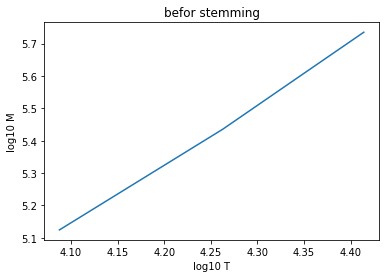

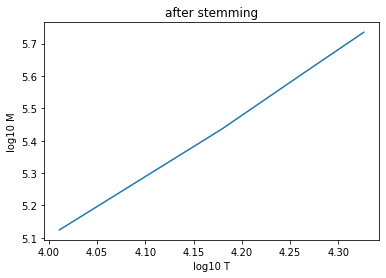

In [12]:
import matplotlib.pyplot as plt

log10_befor_stem = [[log10(i) for i in befor_stem[0]], [log10(i) for i in befor_stem[1]]]
log10_after_stem = [[log10(i) for i in after_stem[0]], [log10(i) for i in after_stem[1]]]

plt.plot(log10_befor_stem[1], log10_befor_stem[0])
plt.title('befor stemming')
plt.xlabel('log10 T')
plt.ylabel('log10 M')
plt.show()

plt.plot(log10_after_stem[1], log10_after_stem[0])
plt.title('after stemming')
plt.xlabel('log10 T')
plt.ylabel('log10 M')
plt.show()

Zip's Law

In [13]:
term_freq = {}
term_freq_stop = {}

for docID in documents:
    _tokenized = my_tokenizer.tokenize_words(documents[str(docID)]['content'])
    for i in _tokenized:
        if i not in term_freq.keys():
            term_freq[i] = 1
        else:
            term_freq[i] +=1
    _stop = [t for t in _tokenized if t not in persian_stopwords]
    for i in _stop:
        if i not in term_freq_stop.keys():
            term_freq_stop[i] = 1
        else:
            term_freq_stop[i] += 1

import operator
term_freq_1 = sorted(term_freq.items(), key=operator.itemgetter(1),reverse=True)
term_freq_stop_1 = sorted(term_freq_stop.items(), key=operator.itemgetter(1),reverse=True)

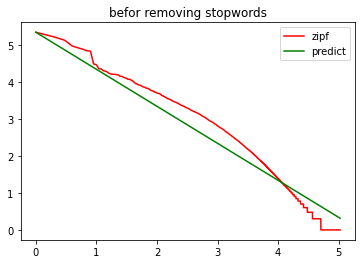

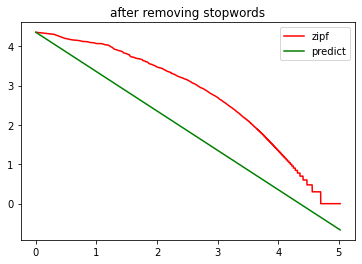

In [14]:
from math import log10
import matplotlib.pyplot as plt

# befor removing stop words
k_1 = term_freq_1[0][1]
zip_1 = [[log10(i+1) for i in range(len(term_freq))], [log10(term_freq_1[n][1]) for n in range(len(term_freq))]]
zip_predict_1 = [[log10(i+1) for i in range(len(term_freq))], [log10(k_1/(i+1)) for i in range(len(term_freq))]]

plt.plot(zip_1[0], zip_1[1], color='r', label='zipf')
plt.plot(zip_predict_1[0], zip_predict_1[1], color='g', label='predict')
plt.title('befor removing stopwords')
plt.legend()
plt.show()

# after removing stop words
k_stop_1 = term_freq_stop_1[0][1]
zip_stop_1 = [[log10(i+1) for i in range(len(term_freq_stop))], [log10(term_freq_stop_1[n][1]) for n in range(len(term_freq_stop))]]
zip_stop_predict_1 = [[log10(i+1) for i in range(len(term_freq_stop))], [log10(k_stop_1/(i+1)) for i in range(len(term_freq_stop))]]

plt.plot(zip_stop_1[0], zip_stop_1[1], color='r', label='zipf')
plt.plot(zip_stop_predict_1[0], zip_stop_predict_1[1], color='g', label='predict')
plt.title('after removing stopwords')
plt.legend()
plt.show()